<a href="https://colab.research.google.com/github/ErBadi/Business-success-prediction/blob/main/Final_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Las Vegas Restaurants Success Prediction

## Introductory code

In [ ]:
#Basics
import pandas as pd
import numpy as np

#Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("dark_background")

# For geospatial
import folium
import geopy

# For clustering
from sklearn import preprocessing, cluster
import scipy

# Prediction
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import preprocessing
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load business dataset and review dataset just from Las Vegas
business = pd.read_csv('/content/drive/MyDrive/REVIEWS BIG DATA/business_data.csv')
review_vegas = pd.read_csv("/content/drive/MyDrive/REVIEWS BIG DATA/review_1.csv")

## EDA

In [ ]:
#Subset of business from Las Vegas
business_vegas = business[business['city'] == 'Las Vegas']

We are going to extract the main category from every business

In [ ]:
#Split categories by ", "
business_vegas['categories'] = business_vegas['categories'].str.split(', ')
business_vegas["main_cat"] = business_vegas["categories"].str[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Quick view of the number of businesses of the main categories 

In [ ]:
# Prepare the dataframe to plot 
plot_df = business_vegas['main_cat'].value_counts().rename_axis('category').reset_index(name='counts')
plot_df

category  counts
0       Restaurants    1840
1          Shopping    1209
2     Home Services     995
3              Food     930
4     Beauty & Spas     899
..              ...     ...
934   Fencing Clubs       1
935       Float Spa       1
936    Herbal Shops       1
937     Cryotherapy       1
938  Paddleboarding       1

[939 rows x 2 columns]

Based on **this information**, and on the one from the **wordclouds EDA** (the appearance of words such as "Raku", "Chef", "Buffet" shows the high relevance of this type of business in the dataset), we conclude that the best businesses to check are the ones whose main category is "**Restaurants**".

In [ ]:
# Create dataframe just with restaurants in Las Vegas - from the business dataset
rest_vegas = business_vegas[business_vegas['main_cat'] == 'Restaurants']
rest_vegas.head(1)

business_id                        name  ... hours     main_cat
17  PZ-LZzSlhSe9utkQYU8pFg  Carluccio's Tivoli Gardens  ...   NaN  Restaurants

[1 rows x 15 columns]

In [ ]:
# Create dataframe just with reviews from restaurants in Las Vegas - from the reviews dataset 
rest_vegas_review = review_vegas.loc[review_vegas['business_id'].isin(rest_vegas["business_id"])]
rest_vegas_review.head(1)

review_id  ...       city
4401  qm97yMwREr7BKkexlwLFbg  ...  Las Vegas

[1 rows x 10 columns]

### Clustering

We want to identify the **main neighbourhoods** in Las Vegas for restaurants **based on its coordinates** (latitude and longitude). For this purpose, we decided to use **K-means neighbours**.

Here, in order to **define the right K** (number of neighbourhoods), we will use the Elbow Method: plotting the variance as a function of the number of clusters and picking the K that flats the curve (lowest derivative).

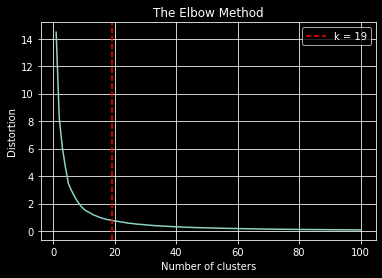

In [ ]:
# Set the variables to use and maximum number of K's to try
X = rest_vegas[["lat","long"]]
max_k = 100

# Iterations over 100 K's
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)

# Find the best K by lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))

# We plot it
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [ ]:
print("We have found that the best value of K is", k)

We have found that the best value of K is 19


Now, we are going to get the different neighbourhoods (**clusters**).

In [ ]:
# We initialize the model
model = cluster.KMeans(n_clusters=k, init='k-means++')

# Start clustering
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)

# Find the centroids businesses
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1

# Add clustering info to the original dataset
rest_vegas[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
rest_vegas.head(5)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


business_id                        name  ... cluster centroids
17   PZ-LZzSlhSe9utkQYU8pFg  Carluccio's Tivoli Gardens  ...      17         0
111  X8mtoSxY8whtmbDlj0D3Aw       Imperial Asian Buffet  ...      16         0
135  bJP4l_BGq2CudEu0m-wNjg    Artisan Fine Dining Room  ...      18         0
240  0G83H_zoum-Q4bWU2olTqQ       Bonjour Bakery & Deli  ...      11         0
494  k2b3niokS_tosjah_rzCPw                 Metro Pizza  ...       9         1

[5 rows x 17 columns]

Now, we are going to create a new column which will be a **popularity** attribute. This new metric is defined as **number of reviews multiplied by the average rating**, and intends to measure the popularity of a business.

In [ ]:
# Define popularity for each business
rest_vegas["popularity"] = rest_vegas["num_reviews"] * rest_vegas["rating"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Now we define if the business belongs to a popular cluster or not
rest_vegas["popular"] = rest_vegas["popularity"] > rest_vegas["popularity"].mean() 
rest_vegas["popular"].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


False    1419
True      421
Name: popular, dtype: int64

Let's plot our neighbourhoods to see them clearly.

In [ ]:
# We define the area of the map we are going to use
city = "Las Vegas"

# Get location
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print(location)

# Keep latitude and longitude only
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

Las Vegas, Clark County, Nevada, United States
[lat, long]: [36.1672559, -115.1485163]


In [ ]:
# Plot variables to use
x, y = "lat", "long"
color = "cluster"
size = "popularity"
popup = "name"
marker = "centroids"
data = rest_vegas.copy()

# Create color column
lst_elements = sorted(list(rest_vegas[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in 
              range(len(lst_elements))]
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])

# Create size column (depending on popularity)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)

# Initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
# Add points (businesses)
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup = folium.Popup(row[popup]),
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)

## Add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))

# Add centroids marker (with the number of cluster)
lst_elements = sorted(list(rest_vegas[marker].unique()))
data[data[marker]==1].apply(lambda row: 
           folium.Marker(location=[row[x],row[y]], 
           popup = folium.Popup(str(row[color])), draggable=False,          
           icon=folium.Icon(color="black")).add_to(map_), axis=1)

# Plot the map
map_

From this map, we clearly see the different neighbourhoods of restaurants in Las Vegas. The **size** of the points is **based on their popularity**. The **information points** indicate which business is at the **center of the neihgbourhood** and which cluster that neighbourhood is. 

In [ ]:
# Get html code to put the map in a web
html_string = map_.get_root().render()

# Save it into a text file
with open('Hoods_map.txt', 'w') as fp: 
    pass
text_file = open("Hoods_map.txt", "w")
text_file.write(html_string)
text_file.close()

Now let's plot all the restaurants taking into account their popularity to see if they are popular businesses or not(if they are above the average or not).

In [ ]:
# Same as previous plot
x, y = "lat", "long"
color = "popular"
size = "popularity"
popup = "name"
marker = "centroids"
data = rest_vegas.copy()

# Create color column
lst_elements = sorted(list(rest_vegas[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in 
              range(len(lst_elements))]
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])

# Create size column 
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)

# Initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)

# Add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup = folium.Popup(row[popup]),
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))

# Add centroids marker
lst_elements = sorted(list(rest_vegas[marker].unique()))
data[data[marker]==1].apply(lambda row: 
           folium.Marker(location=[row[x],row[y]], 
           popup = folium.Popup(row[marker]), draggable=False,          
           icon=folium.Icon(color="black")).add_to(map_), axis=1)

# Plot the map
map_

In [ ]:
# Get html code to put the map in a web
html_string = map_.get_root().render()

# Save it into a text file
with open('Popularity_map.txt', 'w') as fp: 
    pass
text_file = open("Popularity_map.txt", "w")
text_file.write(html_string)
text_file.close()

Based on this information, we have decided to predict the success or failure of a business. We are going to set more variables to help our predictor.

In [ ]:
# Use this column to count the total number of restaurants 
rest_vegas["total_rest"] = True

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


First we want to get the average popularity of each cluster defined as the total popularity of each cluster divided by the total number of restaurants.

In [ ]:
# We group by cluster and sum to get total info of each cluster
popularity_ratio_vegas = rest_vegas.groupby(by = "cluster").sum()
popularity_ratio_vegas["avg_popularity"] = popularity_ratio_vegas["popularity"] / popularity_ratio_vegas["total_rest"]

Now we set the open ratio by cluster defined as the number of open restaurants divided by the total number of restaurants.

In [ ]:
popularity_ratio_vegas["open_ratio"] = popularity_ratio_vegas["open"] / popularity_ratio_vegas["total_rest"]

In [ ]:
# Set the cluster index to a column to operate better
popularity_ratio_vegas["cluster"] = popularity_ratio_vegas.index

In [ ]:
popularity_ratio_vegas.head(1)

lat         long  rating  ...  avg_popularity  open_ratio  cluster
cluster                                    ...                                     
0        2820.599958 -8985.632417   266.0  ...      295.974359    0.576923        0

[1 rows x 12 columns]

In [ ]:
rest_vegas.head(1)

business_id                        name  ... popular total_rest
17  PZ-LZzSlhSe9utkQYU8pFg  Carluccio's Tivoli Gardens  ...   False       True

[1 rows x 20 columns]

Now let's combine the new ratios with our main dataframe to predict.

In [ ]:
# Define two new columns in our main vegas restaurants dataframe
rest_vegas["avg_popularity"] = 0 #13
rest_vegas["open_ratio"] = 0    #14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Get the column number of each column name
cluster_rest = rest_vegas.columns.get_loc("cluster") 
cluster_pop = popularity_ratio_vegas.columns.get_loc("cluster") 
avg_pop_rest = rest_vegas.columns.get_loc("avg_popularity") 
avg_pop_pop = popularity_ratio_vegas.columns.get_loc("avg_popularity")
open_rest = rest_vegas.columns.get_loc("open_ratio") 
open_pop = popularity_ratio_vegas.columns.get_loc("open_ratio")

# We introduce avg_popularity and open_ratio to rest_vegas based on cluster
for i in range(len(popularity_ratio_vegas)):
  for j in range(len(rest_vegas)):
    if rest_vegas.iloc[j,cluster_rest] == popularity_ratio_vegas.iloc[i, cluster_pop]:
      rest_vegas.iloc[j,avg_pop_rest] = popularity_ratio_vegas.iloc[i, avg_pop_pop] 
      rest_vegas.iloc[j,open_rest] = popularity_ratio_vegas.iloc[i, open_pop]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


## Prediction

Now we start our **prediction**, based on **neighbourhood**, **average popularity** by neighbourhood, **open ratio** by neighbourhood, **latituted**, **longitude**, **number of reviews** of each business, **rating** of each business and **popularity** of each business. With all this **we aim to predict the success or failure** of a business (if it is going to be closed or open).

In [ ]:
# Define our predictor variables
x = rest_vegas[["cluster", "avg_popularity", "open_ratio", "lat", "long", "num_reviews", "rating", "popularity"]]
y = rest_vegas["open"]

In [ ]:
# Split the dataset
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [ ]:
print('There are {} samples in the training set and {} samples in the test set.'.format(
x_train.shape[0], x_test.shape[0]))

There are 1472 samples in the training set and 368 samples in the test set.


We are going to try different models and see which performs better.

Let's first try XGBoost model.

In [ ]:
# Initialize model and plot reports 
xgb = XGBClassifier()
xgb.fit(x_train,y_train)
predxgb = xgb.predict(x_test)
print("Confusion Matrix for XGBoost Classifier:")
print(confusion_matrix(y_test,predxgb))
print("Score: ",round(accuracy_score(y_test,predxgb)*100,2))
print("Classification Report:")
print(classification_report(y_test,predxgb))

Confusion Matrix for XGBoost Classifier:
[[ 70  94]
 [ 32 172]]
Score:  65.76
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.43      0.53       164
           1       0.65      0.84      0.73       204

    accuracy                           0.66       368
   macro avg       0.67      0.63      0.63       368
weighted avg       0.66      0.66      0.64       368



Let's use KFold cross validation score.

In [ ]:
cv = KFold(n_splits=5, random_state=0, shuffle=True)
scores = cross_val_score(xgb, x, y, cv=cv)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))

[0.6576087  0.70380435 0.70923913 0.69836957 0.69836957]
Accuracy: 0.69 (+/- 0.04)


In [ ]:
# Random Forest Classifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x, y)
cv = KFold(n_splits=5, random_state=0, shuffle=True)
scores = cross_val_score(clf, x, y, cv=cv)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))

[0.59782609 0.66304348 0.71467391 0.68478261 0.68206522]
Accuracy: 0.67 (+/- 0.08)


In [ ]:
# MULTILAYER PERCEPTRON CLASSIFIER
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train,y_train)
cv = KFold(n_splits=5, random_state=0, shuffle=True)
scores = cross_val_score(mlp, x, y, cv=cv)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))

[0.57065217 0.61141304 0.62771739 0.66032609 0.61141304]
Accuracy: 0.62 (+/- 0.06)


In [ ]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
gbi = GradientBoostingClassifier(learning_rate=0.1,max_depth=5,max_features=0.5,random_state=999999)
gbi.fit(x_train,y_train)
cv = KFold(n_splits=5, random_state=0, shuffle=True)
scores = cross_val_score(gbi, x, y, cv=cv)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores) * 2))

[0.6576087  0.7173913  0.70380435 0.69293478 0.69565217]
Accuracy: 0.69 (+/- 0.04)


From all those models, we saw that **XGBoost** performed better than the rest, achieving a **70% of cross validated accuracy** in **predicting the success or failure** of a business.